# Data preparation

In [0]:
import os
os.chdir('/content/')

In [0]:
os.rename('data1', 'data')

In [0]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from fastai.imports import *
from fastai.structured import *
from sklearn import metrics

In [0]:
df_raw = pd.read_csv(f'{PATH}train.csv', low_memory=False, 
                     parse_dates=["saledate"])

In [0]:
def display_all(df):
  with pd.option_context("display.max_rows", 100, "display.max_columns", 100):
    display(df)

In [0]:
# Checking the imported raw data in the data frame

display(df_raw.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
SalesID,401125,NaN,NaN,NaN,1.91971e+06,909021,1.13925e+06,1.41837e+06,1.63942e+06,2.24271e+06,6.33334e+06
SalePrice,401125,NaN,NaN,NaN,10.1031,0.693621,8.4659,9.5819,10.0858,10.5966,11.8636
MachineID,401125,NaN,NaN,NaN,1.2179e+06,440992,0,1.0887e+06,1.27949e+06,1.46807e+06,2.48633e+06
ModelID,401125,NaN,NaN,NaN,6889.7,6221.78,28,3259,4604,8724,37198
datasource,401125,NaN,NaN,NaN,134.666,8.96224,121,132,132,136,172
auctioneerID,380989,NaN,NaN,NaN,6.55604,16.9768,0,1,2,4,99
YearMade,401125,NaN,NaN,NaN,1899.16,291.797,1000,1985,1995,2000,2013
MachineHoursCurrentMeter,142765,NaN,NaN,NaN,3457.96,27590.3,0,0,0,3025,2.4833e+06
UsageBand,401125,NaN,NaN,NaN,-0.598058,0.93086,-1,-1,-1,-1,2
fiModelDesc,401125,4999,310G,5039,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

In [0]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df_raw.drop('SalePrice', axis = 1), df_raw.SalePrice)

In [0]:
add_datepart(df_raw, 'saledate')
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

In [0]:
train_cats(df_raw)

In [0]:
# Convert raw data into categorical data

df_raw.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

In [0]:
df_raw.UsageBand.cat.set_categories(['High', 'Low', 'Medium'], ordered = True, 
                                   inplace = True)

In [0]:
df_raw.UsageBand = df_raw.UsageBand.cat.codes

In [0]:
import os
os.makedirs('tmp2', exist_ok=True)

In [0]:
df, y, nas = proc_df(df_raw, 'SalePrice')

In [0]:
# Creating validation set

def split_vals(a, n): return a[:n].copy(), a[n:].copy()

n_valid = 12000
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

# Training the model with random forests

In [0]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [0]:
m = RandomForestRegressor(n_jobs = -1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1min 34s, sys: 100 ms, total: 1min 34s
Wall time: 48.4 s
[0.009076306404454709, 0.025651838814634235, 0.9823907752317076, 0.8807117167863725]


In [0]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset = 30000, na_dict = nas)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [0]:
m = RandomForestRegressor (n_jobs = -1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 3 s, sys: 6 ms, total: 3 s
Wall time: 1.68 s
[0.011064686358811238, 0.03785870562822127, 0.9726045294109, 0.7401681971191243]


In [0]:
m = RandomForestRegressor(n_estimators = 1, max_depth = 3, bootstrap = False, n_jobs = -1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 129 ms, sys: 5 ms, total: 134 ms
Wall time: 171 ms
[0.05112207872551128, 0.0572278269903959, 0.41518627190530843, 0.4062887275321615]


In [0]:
draw_tree(m.estimators_[0], df_trn, precision=3)

In [0]:
m = RandomForestRegressor(n_estimators = 1, bootstrap = False, n_jobs = -1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 459 ms, sys: 18 ms, total: 477 ms
Wall time: 581 ms
[2.2783262519817603e-05, 0.04922631894641916, 0.9999998838464792, 0.5607057627605554]


# Further optimization with bagging

In [0]:
m = RandomForestRegressor(n_jobs = -4)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 2.57 s, sys: 5 ms, total: 2.57 s
Wall time: 2.58 s
[0.011210333753952332, 0.03920552733172251, 0.9718785548948138, 0.7213523511133639]


In [0]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([2.20252, 2.24427, 2.21474, 2.23993, 2.23993, 2.18859, 2.38138, 2.22561, 2.18859, 2.30246]),
 2.242802772938829,
 2.2088215008013257)

In [0]:
preds.shape

(10, 12000)

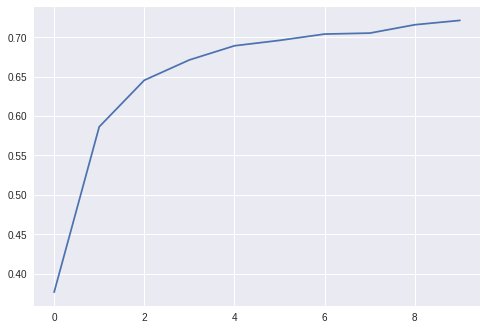

In [0]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)])

In [0]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.01014904087462272, 0.036016459086096, 0.9769510814893675, 0.7648403470683309]


In [0]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.009590571174346208, 0.03746325507327405, 0.9794179089695848, 0.745567958762142]


In [0]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.00960053640113402, 0.036729556106843426, 0.9793751144873848, 0.7554362172726725, 0.8529147525511108]


In [0]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [0]:
set_rf_samples(20000)

In [0]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 9.31 s, sys: 193 ms, total: 9.5 s
Wall time: 6.38 s
[0.023962517861685188, 0.027837369096600034, 0.8772597965616017, 0.8595191393514241, 0.8645022688092396]


In [0]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.022697757688048957, 0.026536531293269574, 0.889874510898147, 0.8723416899135957, 0.8781325927419024]


In [0]:
reset_rf_samples()

In [0]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.007863124430824488, 0.02457903058691248, 0.9867836285513707, 0.8904807947211474, 0.905789886811103]


In [0]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf = 3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.011537937024708976, 0.023535053121782792, 0.971543710665676, 0.8995867209452988, 0.9056556026215166]


In [0]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf = 3, max_features = 0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.011925177292032142, 0.022977965855300056, 0.9696015367931445, 0.9042841317694142, 0.9096124719521697]
